<a href="https://colab.research.google.com/github/Carancho25/Challenge-2-Telecom/blob/main/RevModRegLogv_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install ucimlrepo


In [40]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import warnings
import xgboost as xgb
import plotly.express as px

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate

from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

import joblib
import pickle

In [41]:
dfIranian = pd.read_csv("https://archive.ics.uci.edu/static/public/563/data.csv")

dfEsp = dfIranian.rename(columns={
    'Call  Failure': 'Fallos_Llamadas',
    'Complains' : 'Quejas',
    'Subscription  Length': 'Meses_permanencia',
    'Charge  Amount': 'Cargo',
    'Seconds of Use': 'Total_segundos',
    'Frequency of use': 'Total_llamadas',
    'Frequency of SMS': 'Total_mensajes',
    'Distinct Called Numbers': 'Llamadas_numeros_distintos',
    'Age Group': 'Grupo_edades',
    'Tariff Plan': 'Plan_tarifa',
    'Status': 'Estado_clientes',
    'Age': 'Edad',
    'Customer Value': 'Valor_cliente',
    'Churn': 'Abandono'})

In [42]:
corrMatrix = dfEsp.corr(numeric_only=True)
dfFilt = pd.DataFrame(corrMatrix[['Abandono']])*100
dfFilt


,Abandono
Fallos_Llamadas,-0.898737
Quejas,53.205296
Meses_permanencia,-3.258789
Cargo,-20.230536
Total_segundos,-29.893454
Total_llamadas,-30.333734
Total_mensajes,-22.075364
Llamadas_numeros_distintos,-27.886687
Grupo_edades,-1.455019
Plan_tarifa,-10.585294


In [43]:
dfEsp.columns

Index(['Fallos_Llamadas', 'Quejas', 'Meses_permanencia', 'Cargo',
       'Total_segundos', 'Total_llamadas', 'Total_mensajes',
       'Llamadas_numeros_distintos', 'Grupo_edades', 'Plan_tarifa',
       'Estado_clientes', 'Edad', 'Valor_cliente', 'Abandono'],
      dtype='object')

In [44]:
selected_columns = ['Abandono', 'Fallos_Llamadas', 'Meses_permanencia', 'Cargo',
       'Total_segundos', 'Total_llamadas', 'Total_mensajes',
       'Llamadas_numeros_distintos', 'Grupo_edades', 'Plan_tarifa', 'Edad',
       'Valor_cliente']

In [45]:
# Calcular la matriz de correlación completa (sin filtrar)
corrMatrix = dfEsp.corr(numeric_only=True)

# Crear el heatmap con todas las correlaciones
fig = px.imshow(
    corrMatrix,  # <-- Usar la matriz completa
    text_auto=True,  # Muestra los valores numéricos
    color_continuous_scale='RdBu',  # Escala de colores (rojo=negativo, azul=positivo)
    zmin=-1,  # Rango mínimo de correlación
    zmax=1,   # Rango máximo de correlación
    title='Matriz de Correlación'
)

# Ajustes de diseño
fig.update_layout(
    width=800,  # Ancho del gráfico
    height=800,  # Alto del gráfico (puedes ajustarlo)
    xaxis_title='Variables',
    yaxis_title='Variables',
    xaxis=dict(tickangle=90)  # Rotar etiquetas del eje X para mejor legibilidad
)

fig.show()

In [46]:
dfEnt = dfEsp[['Abandono','Total_llamadas','Valor_cliente', 'Fallos_Llamadas','Meses_permanencia']]

In [47]:
# Calcular la matriz de correlación completa (sin filtrar)
corrMatrix = dfEnt.corr(numeric_only=True)

# Crear el heatmap con todas las correlaciones
fig = px.imshow(
    corrMatrix,  # <-- Usar la matriz completa
    text_auto=True,  # Muestra los valores numéricos
    color_continuous_scale='RdBu',  # Escala de colores (rojo=negativo, azul=positivo)
    zmin=-1,  # Rango mínimo de correlación
    zmax=1,   # Rango máximo de correlación
    title='Matriz de Correlación'
)

# Ajustes de diseño
fig.update_layout(
    width=800,  # Ancho del gráfico
    height=800,  # Alto del gráfico (puedes ajustarlo)
    xaxis_title='Variables',
    yaxis_title='Variables',
    xaxis=dict(tickangle=90)  # Rotar etiquetas del eje X para mejor legibilidad
)

fig.show()

In [48]:
x = dfEnt.drop(columns=['Abandono'])
y = dfEnt['Abandono']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

#Balanceo de Clases disminuye los datos
from imblearn import under_sampling
undersampling = RandomUnderSampler(random_state=42, sampling_strategy='auto')
xTrainBal, yTrainBal = undersampling.fit_resample(x_train, y_train)
print(yTrainBal.value_counts())
print(yTrainBal.value_counts(normalize=True)*100)


Abandono
0    333
1    333
Name: count, dtype: int64
Abandono
0    50.0
1    50.0
Name: proportion, dtype: float64


In [49]:
# 1. Definir el nuevo modelo (Regresión Logística)
# Usamos max_iter=1000 para asegurar la convergencia en datasets numéricos
mdLogistUnder = LogisticRegression(random_state=42, max_iter=1000)

# 2. Definir el Pipeline con Scaler (Vital para variables numéricas)
# Nota: 'undersampling' debe estar definido previamente como RandomUnderSampler()
pipeline = imbpipeline([
    ('scaler', RobustScaler()), # Añadimos esto para normalizar tus variables numéricas
    ('undersampling', undersampling),
    ('modelo Logístico undersampling', mdLogistUnder)
])

# 3. Validación Cruzada (Mantenemos tu estructura de StratifiedKFold)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Define skf here
cvResultados = cross_validate(pipeline, x, y, cv=skf, scoring='recall')

# 4. Entrenamiento final
# Importante: el pipeline se encarga de escalar y balancear automáticamente
pipeline.fit(xTrainBal, yTrainBal) # Use xTrainBal and yTrainBal

Pipeline(steps=[('scaler', RobustScaler()),
                ('undersampling', RandomUnderSampler(random_state=42)),
                ('modelo Logístico undersampling',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [50]:
# En lugar de y_pred = pipeline.predict(xTest)
probabilidades = pipeline.predict_proba(x_test)[:, 1]
y_pred_ajustado = (probabilidades >= 0.4).astype(int)

print(classification_report(y_test, y_pred_ajustado))

              precision    recall  f1-score   support

           0       0.97      0.63      0.77       783
           1       0.34      0.90      0.49       162

    accuracy                           0.68       945
   macro avg       0.65      0.76      0.63       945
weighted avg       0.86      0.68      0.72       945



Reporte de Clasificación - Regresión Logística (Umbral 40%):
              precision    recall  f1-score   support

           0       0.97      0.63      0.77       783
           1       0.34      0.90      0.49       162

    accuracy                           0.68       945
   macro avg       0.65      0.76      0.63       945
weighted avg       0.86      0.68      0.72       945



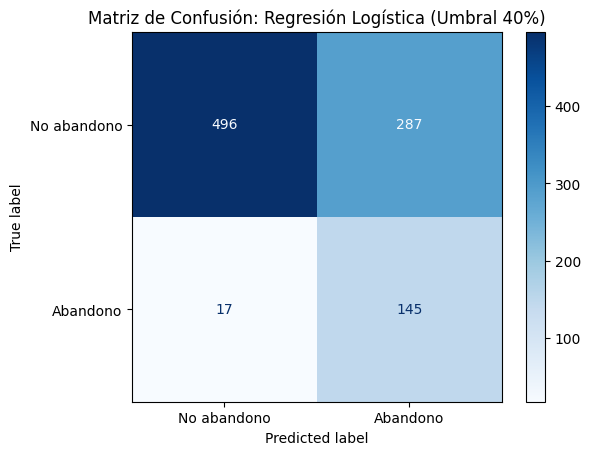

In [51]:
# 1. Obtener las probabilidades de la clase 1 (Abandono)
# Usamos el pipeline que ya tiene el Scaler y la Logística
y_probabilidades = pipeline.predict_proba(x_test)[:, 1]

# 2. Aplicar el umbral del 40% (0.4) que definiste como óptimo
y_previsto_ajustado = (y_probabilidades >= 0.4).astype(int)

# 3. Reporte de clasificación con el nuevo umbral
print("Reporte de Clasificación - Regresión Logística (Umbral 40%):")
print(classification_report(y_test, y_previsto_ajustado))

# 4. Matriz de Confusión
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_previsto_ajustado,
    display_labels=['No abandono', 'Abandono'],
    cmap='Blues'
)

# 5. Guardar el gráfico con el nombre correcto
plt.title('Matriz de Confusión: Regresión Logística (Umbral 40%)')
plt.savefig('matrizConfusionLogistica_Umbral40.png', dpi=600, bbox_inches='tight')
plt.show()

In [52]:
exactitud_ajustada = accuracy_score(y_test, y_previsto_ajustado)
print(f'La exactitud real del modelo (Umbral 40%) es: {exactitud_ajustada:.4f}')

La exactitud real del modelo (Umbral 40%) es: 0.6783


In [53]:
coeficientes = pipeline.named_steps['modelo Logístico undersampling'].coef_[0]

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Seleccionar solo las variables numéricas (X)
X_vif = dfEsp.drop(['Abandono'], axis=1)

# 2. Es necesario añadir una constante para el cálculo del VIF
X_vif_const = X_vif.assign(constante=1)

# 3. Calcular VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i)
                   for i in range(X_vif_const.shape[1])]

# 4. Mostrar resultados (Filtrando la constante)
print(vif_data[vif_data['Variable'] != 'constante'].sort_values(by="VIF", ascending=False))

                      Variable        VIF
12               Valor_cliente  55.771092
6               Total_mensajes  43.486055
4               Total_segundos  22.779944
5               Total_llamadas  18.882664
11                        Edad  14.853635
8                 Grupo_edades  14.171153
3                        Cargo   3.189919
0              Fallos_Llamadas   2.924264
7   Llamadas_numeros_distintos   2.474734
10             Estado_clientes   1.850072
9                  Plan_tarifa   1.595108
2            Meses_permanencia   1.182062
1                       Quejas   1.157264


In [55]:
# Crear el DataFrame de importancia (usamos el valor absoluto para la importancia total)
importancia_df = pd.DataFrame({
    'Features': x.columns,
    'Coeficiente': coeficientes,
    'Importancia_Abs': np.abs(coeficientes)
}).sort_values(by='Importancia_Abs', ascending=False).reset_index(drop=True)

# 3. Graficar con Plotly (usando el coeficiente real para ver dirección)
fig_importancia = px.bar(
    importancia_df,
    x='Features',
    y='Coeficiente',
    text_auto='.2f',
    title='Impacto de Variables (Coeficientes) - Regresión Logística',
    color='Coeficiente',
    color_continuous_scale='RdBu_r' # Rojo para positivo (abandono), Azul para negativo
)

fig_importancia.update_traces(textposition='outside')
fig_importancia.show()

In [56]:
# 1. Extraer coeficientes y nombres de columnas
coefs = pipeline.named_steps['modelo Logístico undersampling'].coef_[0]
nombres = x.columns

# 2. Crear el DataFrame de impacto (reemplazando tu caracteImportMdXgbUnder)
df_impacto_log = pd.DataFrame([coefs], columns=nombres, index=['Coeficiente']).round(4)

# 3. Mostrar la transpuesta para lectura vertical
df_resumen_T = df_impacto_log.T.sort_values(by='Coeficiente', ascending=False)
print(df_resumen_T)

                   Coeficiente
Fallos_Llamadas         1.4080
Meses_permanencia      -0.0703
Valor_cliente          -0.6282
Total_llamadas         -2.2630


In [57]:
# Eliminamos las variables con alta multicolinealidad y posibles fugas de datos
columnas_a_eliminar = ['Valor_cliente', 'Grupo_edades', 'Total_mensajes', 'Total_segundos']

# Filtra solo las columnas que existen en x
columnas_existentes_a_eliminar = [col for col in columnas_a_eliminar if col in x.columns]
x_limpio = x.drop(columns=columnas_existentes_a_eliminar)

# Verifica el nuevo VIF (opcional) o procede al entrenamiento
print(f"Variables restantes: {x_limpio.columns.tolist()}")

Variables restantes: ['Total_llamadas', 'Fallos_Llamadas', 'Meses_permanencia']


In [58]:
# Para este bloque de GridSearchCV, los cambios son estructurales porque la Regresión Logística tiene parámetros muy distintos a los de XGBoost. Además, como hemos conversado, es imprescindible añadir el Scaler en el pipeline para que el modelo funcione correctamente con tus variables numéricas.

# Aquí tienes el código adaptado para la Regresión Logística:

# Python

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler # Fundamental para Logística

# 1. Redefinir pipeline con Scaler, Undersampling y LogisticRegression
pipeline_log = imbpipeline([
    ('scaler', RobustScaler()),
    ('undersampling', RandomUnderSampler(random_state=42)),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42))
])

# 2. Hiperparámetros específicos para Regresión Logística
# Cambiamos n_estimators/max_depth por C (regularización) y penalty
param_grid_log = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100],          # Fuerza de regularización
    'log_reg__penalty': ['l1', 'l2'],              # Tipo de penalización
    'log_reg__solver': ['liblinear', 'saga'],      # Algoritmos que soportan l1 y l2
    'undersampling__sampling_strategy': [0.6, 0.8, 1.0] # Proporción de balanceo
}

# 3. GridSearch (Cambiamos el scoring a 'recall' si quieres priorizar detección,
# o mantenemos 'f1' para balance como el modelo Random Forest de diciembre)
grid_search_log = GridSearchCV(
    pipeline_log,
    param_grid_log,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='recall', # Recomendado para tu objetivo de no perder clientes
    n_jobs=-1,
    verbose=1
)

grid_search_log.fit(x_train, y_train)

print(f"Mejores parámetros Logística: {grid_search_log.best_params_}")
print(f"Mejor score (Recall): {grid_search_log.best_score_:.4f}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Mejores parámetros Logística: {'log_reg__C': 0.01, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear', 'undersampling__sampling_strategy': 1.0}
Mejor score (Recall): 0.9129


In [59]:
print("Formulario de Predicción de Abandono - Modelo Logístico")
print("\n" + "="*50)

datos_usuario = {}

# Campos actualizados según el análisis de VIF y Relevancia
# Eliminamos Valor_cliente y Grupo_edades
campos = [
    ('Fallos_Llamadas', "Número de fallos de llamada: ", int),
    ('Quejas', "El cliente ha presentado quejas (si/no): ", str),
    ('Meses_permanencia', "Meses de antigüedad del cliente: ", int),
    ('Total_llamadas', "Cantidad total de llamadas realizadas: ", int),
    ('Cargo', "Monto del cargo mensual: ", int),
    ('Edad', "Edad del cliente: ", int)
]

for campo, mensaje, tipo in campos:
    while True:
        try:
            valor = input(mensaje)
            if tipo == str:
                # Lógica para convertir si/no a binario (1/0)
                if valor.lower() in ['si', 'sí', '1', 'yes', 'y']:
                    datos_usuario[campo] = 1
                elif valor.lower() in ['no', '0', 'n']:
                    datos_usuario[campo] = 0
                else:
                    print("Por favor ingrese 'si' o 'no'")
                    continue
            else:
                datos_usuario[campo] = tipo(valor)
            break
        except ValueError:
            print(f"Error: Por favor ingrese un valor numérico válido.")

# Convertir a DataFrame para que el pipeline pueda procesarlo (escalar y predecir)
df_input = pd.DataFrame([datos_usuario])

Formulario de Predicción de Abandono - Modelo Logístico

Número de fallos de llamada: 55
El cliente ha presentado quejas (si/no): SI
Meses de antigüedad del cliente: SI
Error: Por favor ingrese un valor numérico válido.
Meses de antigüedad del cliente: 12
Cantidad total de llamadas realizadas: 10
Monto del cargo mensual: 100
Edad del cliente: 55
